# Project Summary

### Objective
Find document similarity between Rav Schachter shiurim (speeches). Because he has taught the same gemaras over and over, in different years, many of his shiurim may actually be the same.

In [1]:
###############
## Libraries ##
###############

# Vectorizers and Similarity Alogrithms
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import jaccard_score
from joblib import Parallel, delayed
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Plotting
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and File Read-in
import os
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from glob import glob
import re

### Some Background on TF-IDF

TF - Term Frequency measures how often a word appears in, say, a document. This is computed as the ratio between the number of times the word is in the document and the number of words in the document.

$$ TF = \frac{word\_occurence\_in\_doc}{number\_of\_words\_in\_doc}$$

IDF - Inverse Document Frequency measures how often a word appears in a collection of documents (a “corpus”). This value decreases the more the word is used, hence, inverse. This helps tune out stop words like 'the' or 'and' that don't really contribute to document similarity. The IDF ratio is just the ratio between the number of documents in your corpus and the number of documents that have the word you’re evaluating.

$$ IDF = \frac{number\_of\_docs\_in\_corpus}{number\_of\_docs\_with\_given\_word}$$

The TF and IDF parts are multiplied together to get the actual TF-IDF value. This gives us a metric for how much each word makes a document in the corpus unique.

$$ TF\_IDF = word\_frequency\_per\_doc \times doc\_frequency\_per\_word$$

# Preliminary Steps: Testing a Basic Example

As a starting point for my code, I used the TF-IDF method with a simple example. 

Sourced from https://makeshiftinsights.com/blog/tf-idf-document-similarity/

In [2]:
# Tuple corpus with titles and text
sample_corpus = [
    ('Alaska', 'We the people of Alaska, grateful to God and to those who founded our nation'),
    ('New Jersey', 'We, the people of the State of New Jersey, grateful to Almighty God for the civil and religious liberty which He hath so long permitted us to enjoy, and looking to Him for a blessing upon our endeavors to secure and transmit the same unimpaired to succeeding generations, do ordain and establish this Constitution.'),
    ('Rhode Island', 'We, the people of the State of Rhode Island and Providence Plantations, grateful to Almighty God for the civil and religious liberty which He hath so long permitted us to enjoy, and looking to Him for a blessing upon our endeavors to secure and to transmit the same, unimpaired, to succeeding generations, do ordain and establish this Constitution of government.'),
    ('Arizona', 'We the people of the State of Arizona, grateful to Almighty God for our liberties, do ordain this Constitution.'),
    ('Hawaii', 'We, the people of Hawaii, grateful for Divine Guidance, and mindful of our Hawaiian heritage and uniqueness as an island State'),
    ('Wyoming', 'We, the people of the State of Wyoming, grateful to God for our civil, political and religious liberties, and desiring to secure them to ourselves and perpetuate them to our posterity, do ordain and establish this Constitution.')
]

# Extract titles and texts
sample_titles, sample_texts = zip(*sample_corpus)

# Slice the first three for a mini sample to perform preliminary testing on
mini_sample_texts  = sample_texts[:3]
mini_sample_titles = sample_titles[:3]

Typically, TF-IDF is calculated for each word within each document to produce a "document term matrix". This is a matrix where the **rows** represent each *document* and the **columns** represent each unique *word* in the corpus.

I import and use the sklearn built in TF-IDF method to obtain the matrix for my elementary example data.

In [91]:
def create_matrix(corpus, verbose=False, vocab=False):
    
    # Generate the matrix on the first three preambles
    vectorizer = TfidfVectorizer()
    matrix = vectorizer.fit_transform(corpus)

    # Display the vocabulary list 
    vocabulary = vectorizer.get_feature_names_out()
    print("\nVocab\n", vocabulary, "-> length", len(set(vocabulary)))

    # Display the matrix
    if verbose:
        print("\nFreq Matrix\n", matrix.toarray())
        print()

    if vocab: return matrix, vocabulary
        
    return matrix

mini_sample_matrix = create_matrix(mini_sample_texts, verbose=True)


Vocab
 ['alaska' 'almighty' 'and' 'blessing' 'civil' 'constitution' 'do'
 'endeavors' 'enjoy' 'establish' 'for' 'founded' 'generations' 'god'
 'government' 'grateful' 'hath' 'he' 'him' 'island' 'jersey' 'liberty'
 'long' 'looking' 'nation' 'new' 'of' 'ordain' 'our' 'people' 'permitted'
 'plantations' 'providence' 'religious' 'rhode' 'same' 'secure' 'so'
 'state' 'succeeding' 'the' 'this' 'those' 'to' 'transmit' 'unimpaired'
 'upon' 'us' 'we' 'which' 'who'] -> length 51

Freq Matrix
 [[0.32994266 0.         0.19486945 0.         0.         0.
  0.         0.         0.         0.         0.         0.32994266
  0.         0.19486945 0.         0.19486945 0.         0.
  0.         0.         0.         0.         0.         0.
  0.32994266 0.         0.19486945 0.         0.19486945 0.19486945
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.19486945 0.
  0.32994266 0.3897389  0.         0.         0.         0.
  0.19486945 0.

Taking the product of the matrix with its transpose will result in a document similarity matrix. This shows how similar documents are to each other. The diagonal of 1’s indicates the document's similarity to itself.

I use a few diferent metrics for similarity. Jaccard similarity is complex to calculate, so I create funtion for this. The rest I calculate directly in a  `similarities`  function

For example:

In [144]:
# Calculate Jaccard similarity matrix efficiently with parallelization
def compute_jaccard(i, matrix):
    similarities = []
    for j in range(i+1, matrix.shape[0]):  # Start from i+1 to avoid self-comparison and redundant computations
        similarities.append(jaccard_score(matrix[i].toarray().flatten() > 0, matrix[j].toarray().flatten() > 0))
    return similarities

def jaccard_similarity(matrix):
    num_docs = matrix.shape[0]
    
    # Parallel computation of Jaccard similarities
    jaccard_similarities = Parallel(n_jobs=-1)(delayed(compute_jaccard)(i, matrix) for i in range(num_docs))
    
    # Reshape the flattened list into a square matrix
    jaccard_sim_matrix = np.zeros((num_docs, num_docs))
    for i, similarities in enumerate(jaccard_similarities):
        for j, similarity in enumerate(similarities):
            jaccard_sim_matrix[i, j+i+1] = similarity
    jaccard_sim_matrix += jaccard_sim_matrix.T  # Make the matrix symmetric    
    np.fill_diagonal(jaccard_sim_matrix, 1)     # Set diagonal elements to 1

    return jaccard_sim_matrix

print(jaccard_similarity(mini_sample_matrix))

[[1.         0.19565217 0.18367347 0.34782609 0.26923077 0.28125   ]
 [0.19565217 1.         0.84782609 0.34883721 0.17647059 0.3877551 ]
 [0.18367347 0.84782609 1.         0.32608696 0.18867925 0.36538462]
 [0.34782609 0.34883721 0.32608696 1.         0.28571429 0.51724138]
 [0.26923077 0.17647059 0.18867925 0.28571429 1.         0.24324324]
 [0.28125    0.3877551  0.36538462 0.51724138 0.24324324 1.        ]]


In [129]:
def similarities(matrix, verbose=False):
    # Compute Pairwise similarity matrix: Take the product of the matrix with its transpose.
    pairwise_sim_matrix = (matrix * matrix.transpose()).toarray()
    print("\nPairwise Similarity", pairwise_sim_matrix.shape)
    if verbose: print(pairwise_sim_matrix)
    
    # Compute Cosine similarity matrix
    cosine_sim_matrix = cosine_similarity(matrix, matrix)
    print("\nCosine Similarity", cosine_sim_matrix.shape)
    if verbose: print(cosine_sim_matrix)

    # Compute Jaccard similarity matrix
    jaccard_sim_matrix = jaccard_similarity(matrix)
    print("\nJaccard Similarity", jaccard_sim_matrix.shape)
    if verbose: print(jaccard_sim_matrix)

    return {"Pairwise": pairwise_sim_matrix, "Cosine": cosine_sim_matrix, "Jaccard": jaccard_sim_matrix}

mini_sample_sims = similarities(mini_sample_matrix, verbose=True)


Pairwise Similarity (3, 3)
[[1.         0.43323303 0.4466953 ]
 [0.43323303 1.         0.92587632]
 [0.4466953  0.92587632 1.        ]]

Cosine Similarity (3, 3)
[[1.         0.43323303 0.4466953 ]
 [0.43323303 1.         0.92587632]
 [0.4466953  0.92587632 1.        ]]

Jaccard Similarity (3, 3)
[[0.         0.19565217 0.18367347]
 [0.19565217 0.         0.84782609]
 [0.18367347 0.84782609 0.        ]]


### Visualization

Now to vizualize the data. I use a heatmap and an Isomap plot for vizualisation.


Vocab
 ['alaska' 'almighty' 'an' 'and' 'arizona' 'as' 'blessing' 'civil'
 'constitution' 'desiring' 'divine' 'do' 'endeavors' 'enjoy' 'establish'
 'for' 'founded' 'generations' 'god' 'government' 'grateful' 'guidance'
 'hath' 'hawaii' 'hawaiian' 'he' 'heritage' 'him' 'island' 'jersey'
 'liberties' 'liberty' 'long' 'looking' 'mindful' 'nation' 'new' 'of'
 'ordain' 'our' 'ourselves' 'people' 'permitted' 'perpetuate'
 'plantations' 'political' 'posterity' 'providence' 'religious' 'rhode'
 'same' 'secure' 'so' 'state' 'succeeding' 'the' 'them' 'this' 'those'
 'to' 'transmit' 'unimpaired' 'uniqueness' 'upon' 'us' 'we' 'which' 'who'
 'wyoming'] -> length 69

Pairwise Similarity (6, 6)
[[1.         0.35526966 0.37073433 0.3213806  0.18947988 0.36416614]
 [0.35526966 1.         0.91345047 0.46947515 0.24377412 0.56261738]
 [0.37073433 0.91345047 1.         0.45717928 0.28412447 0.5763232 ]
 [0.3213806  0.46947515 0.45717928 1.         0.26186971 0.47987523]
 [0.18947988 0.24377412 0.28412447 

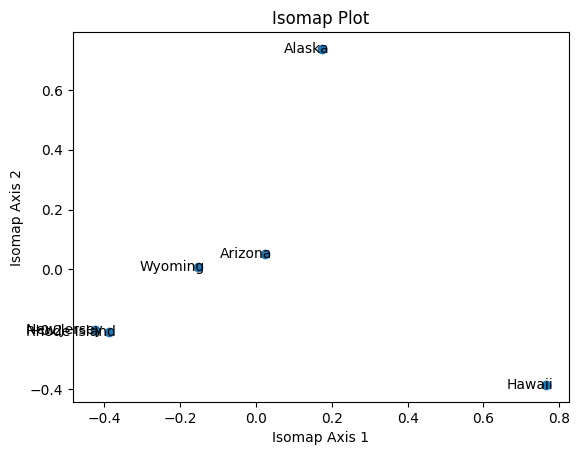

<Figure size 1000x800 with 0 Axes>

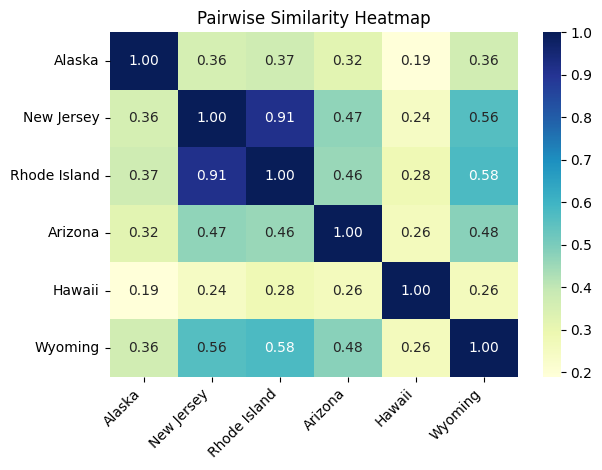

<Figure size 1000x800 with 0 Axes>

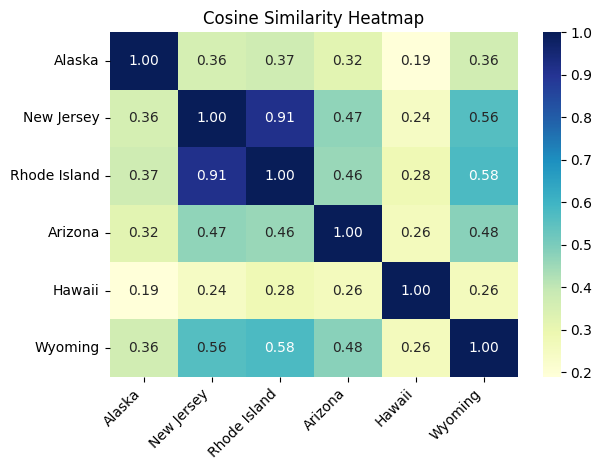

<Figure size 1000x800 with 0 Axes>

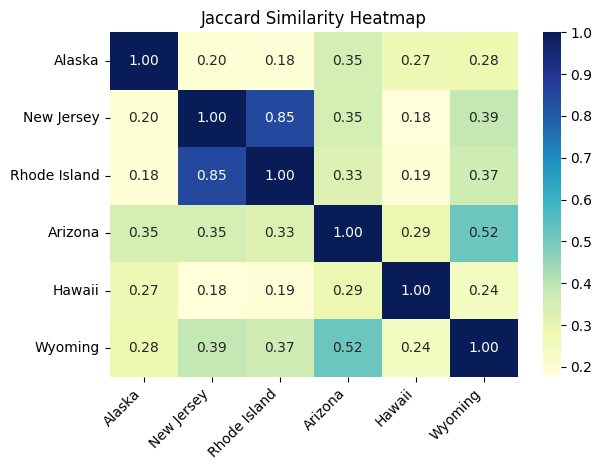

<Figure size 1000x800 with 0 Axes>

In [145]:
def isomap_plot(titles, matrix):
    # Isomap for dimensionality reduction
    n_neighbors = min(5, len(titles) - 1)  # Adjusted n_neighbors value
    iso = Isomap(n_neighbors=n_neighbors, n_components=2)
    reduced_data_iso = iso.fit_transform(matrix)
    
    # Isomap Plot
    plt.scatter(reduced_data_iso[:, 0], reduced_data_iso[:, 1])
    for i, title in enumerate(titles):
        plt.annotate(title, (reduced_data_iso[i, 0], reduced_data_iso[i, 1]), xytext=(5, -5), textcoords='offset points', ha='right', va='bottom')
    plt.title('Isomap Plot')
    plt.xlabel('Isomap Axis 1')
    plt.ylabel('Isomap Axis 2')
    plt.figure(figsize=(10, 8))
    plt.show()

def heatmap_plot(titles, sims):
    # for all the similarity matrices generate a Heatmap Plot
    for ID in sims: 
        sns.heatmap(sims[ID], annot=True, fmt=".2f", cmap='YlGnBu', xticklabels=titles, yticklabels=titles)
        plt.title(f'{ID} Similarity Heatmap')
        plt.xticks(rotation=45, ha='right')             # formatting the titles on the x-axis
        plt.yticks(rotation=0)                          # formatting the titles on the y-axis
        plt.tight_layout()
        plt.figure(figsize=(10, 8))
        plt.show()

# Generate the matrix and similarity matrix for the full corpus
sample_matrix = create_matrix(sample_texts)
sample_sims = similarities(sample_matrix, verbose=True)

# Generate the plots
isomap_plot(sample_titles, sample_matrix)
heatmap_plot(sample_titles, sample_sims)

# Processing the Small Dataset

Now that I have a working TF-IDF algorithm and vizualisation method, I can begin to bring in my data.

I start with just a few of the shiurim from a folder called `rav_shechter_mini` and then later will bring in all of the data

### Path Validation

First, I check that my file path works

In [6]:
def get_file_names(path, verbose=False):
    
    # Check if the path is a directory
    if os.path.isdir(path):
        print(f"'\n{path}' is a directory.")
    else:
        print(f"'\n{path}' is not a directory or does not exist.")

    # Get all text files from the specified folder
    file_names = glob(path + '/*.txt')

    # Print results
    if verbose:
        print("\nFile Names")
        for file in file_names: 
            print(file)
        
    return file_names

mini_path = r'/home/jupyter-sarale2003@gmail.c-2cf43/Machine-Learning-sp24/notebooks/FinalProject/rav_shachter_mini'
mini_file_names = get_file_names(mini_path, verbose=True)

'
/home/jupyter-sarale2003@gmail.c-2cf43/Machine-Learning-sp24/notebooks/FinalProject/rav_shachter_mini' is a directory.

File Names
/home/jupyter-sarale2003@gmail.c-2cf43/Machine-Learning-sp24/notebooks/FinalProject/rav_shachter_mini/703899_base.txt
/home/jupyter-sarale2003@gmail.c-2cf43/Machine-Learning-sp24/notebooks/FinalProject/rav_shachter_mini/703779_base.txt
/home/jupyter-sarale2003@gmail.c-2cf43/Machine-Learning-sp24/notebooks/FinalProject/rav_shachter_mini/703731_base.txt
/home/jupyter-sarale2003@gmail.c-2cf43/Machine-Learning-sp24/notebooks/FinalProject/rav_shachter_mini/703978_base.txt
/home/jupyter-sarale2003@gmail.c-2cf43/Machine-Learning-sp24/notebooks/FinalProject/rav_shachter_mini/703768_base.txt


### Preprocessing

Next, I need to read in each document and do some preprocessing.

The first 24 characters of each line is the timestamp from the recording, so I will need to slice that off. I also need to preprocess the data. I use the function `preprocess_text` provided to me in part by Rachel (Bodek) Issacs.

Rachel processed the data in a few ways:
1. Lowercasing
2. Removing punctuation
3. Removing stop words
4. Stemming
5. Lemmatization

When I tried using all of these processing steps the vocabulary was too large, and it took too long to process my larger dataset. This was the initial function I started with:

In [7]:
def preprocess_text1(doc):
    # Variables
    timestamp_pattern = r'\[\d{2}:\d{2}\.\d{3} -> \d{2}:\d{2}\.\d{3}\]'
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    remove_punctuation = str.maketrans('', '', string.punctuation)
    
    # Removing Timestamp
    text = re.sub(timestamp_pattern, '', doc, flags=re.MULTILINE)
    
    # Lowercasing & Removing Punctuation
    text1 = text.lower().translate(remove_punctuation)

    # Tokenization (split the string into individual words)
    tokens = word_tokenize(text1)

    # Stemming (cuts off endings), Removing Stop Words
    stemmed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    
    # Lemmatization (ran -> run) & Removing Stop Words
    processed_tokens = [lemmatizer.lemmatize(word) for word in stemmed_tokens if word not in stop_words]

    # Joining tokens back into text
    preprocessed_text = ' '.join(processed_tokens)

    return preprocessed_text

After experimentation applying different combinations of the preprocessing steps to the mini dataset (but always removing the stop words and non-English/Hebrew characters, as I found it obvious that this would decrease vocabulary size), I found the following results for vocabulary size, i.e. how many words are in the vocabulary:

Interestingly, removing punctuation always resulted in an increase in vocabulary size. The clear winners were:

    Stemming                                          - 6472
    Lowercasing, Stemming                             - 6419
    Lowercasing, Stemming, Lemmatizing                - 6404
    Lowercasing, Lemmatizing, Stemming                - 6412

For the sake of time complexity, it's probably best to go with the simplest processing method and cut out the lemmatizing.

Then I realized that there was an error in my timestamp pattern. It did't account for all possible variations of timestamps. The original pattern was:

    r'\[\d{2}:\d{2}\.\d{3} -> \d{2}:\d{2}\.\d{3}\]'

I changed the pattern to:

    r'\[(\d{2}:\d{2}:\d{2}\.\d{3}|\d{2}:\d{2}:\d{2}\.\d{3}|\d{2}:\d{2}\.\d{3}|\d{2}:\d{2}\.\d{3}|\d{2}:\d{2}\.\d{3}|\d{2}:\d{2}:\d{2}\.\d{3}) ->
    (\d{2}:\d{2}:\d{2}\.\d{3}|\d{2}:\d{2}:\d{2}\.\d{3}|\d{2}:\d{2}\.\d{3}|\d{2}:\d{2}\.\d{3}|\d{2}:\d{2}\.\d{3}|\d{2}:\d{2}:\d{2}\.\d{3})\]'

That worked. Then I had to retest all of my experimentation. Yay! This is what I found for vocabulary length with each preprocessing combination:

Yet again, we find that the winners were:

    Stemming                                          - 6328
    Lowercasing, Stemming                             - 6268
    Lowercasing, Stemming, Lemmatizing                - 6260
    Lowercasing, Lemmatizing, Stemming                - 6267

But what I did find from retesting is that none of the preprocessing steps caused the vocabulary to INCREASE, which is what was happening when I was removing the timestamp incorrectly.

For the sake of time complexity, it's probably best to go with the simplest processing method and cut out the lemmatizing.

In [211]:
### JUNK

doc = "odin live 1700 menchazkoin hello00 fdbh0bvd 1700vdv"

eng_hebr   = re.compile(r'\b(?!\d*\\b)[a-zA-Zא-ת\\s]+\b') #re.compile(r'[a-zA-Z\\s]+')

# Lowercasing
doc = doc.lower()

# Tokenization (split the string into individual words)
tokens = word_tokenize(doc)

# Stemming (cuts off endings), Removing Stop Words & Non-English/Hebrew Characters
stemmed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and re.search(eng_hebr, word)]

# Joining tokens back into text
preprocessed_text = ' '.join(stemmed_tokens)

print(preprocessed_text)

odin live menchazkoin


In [212]:
# CONSTANTS for preprocessing
ID_pattern = re.compile(r'([^/]+)\.txt$')
stop_words = set(stopwords.words('english'))
eng_hebr   = re.compile(r'\b(?!\d*\\b)[a-zA-Zא-ת\\s]+\b') #re.compile(r'[a-zA-Z\\s]+')  r'(?![\d])[a-zA-Zא-ת\\s]+'
stemmer    = PorterStemmer()
# lemmatizer = WordNetLemmatizer()
# remove_punctuation = str.maketrans('', '', string.punctuation)
# Matches timestamps in various formats within square brackets, including milliseconds, seconds, minutes, and hours
timestamp_pattern = r'\[(\d{2}:\d{2}:\d{2}\.\d{3}|\d{2}:\d{2}:\d{2}\.\d{3}|\d{2}:\d{2}\.\d{3}|\d{2}:\d{2}\.\d{3}|\d{2}:\d{2}\.\d{3}|\d{2}:\d{2}:\d{2}\.\d{3}) -> (\d{2}:\d{2}:\d{2}\.\d{3}|\d{2}:\d{2}:\d{2}\.\d{3}|\d{2}:\d{2}\.\d{3}|\d{2}:\d{2}\.\d{3}|\d{2}:\d{2}\.\d{3}|\d{2}:\d{2}:\d{2}\.\d{3})\]'

def preprocess_text(doc):    
    # Lowercasing
    doc = doc.lower()
    
    # Tokenization (split the string into individual words)
    tokens = word_tokenize(doc)
    
    # Stemming (cuts off endings), Removing Stop Words & Non-English/Hebrew Characters
    stemmed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and re.search(eng_hebr, word)]

    # Joining tokens back into text
    preprocessed_text = ' '.join(stemmed_tokens)

    return preprocessed_text

def generate_titles_texts(file_names, verbose=False):
    
    texts  = []   # to store the documents as strings
    titles = []   # to store the document titles

    if verbose: print("\nBEFORE PREPROCESSING")
        
    for name in file_names:                        # for each file in the folder
        with open(name, 'r') as f:                 # safe open the file
            doc_dirty = f.read().replace('\n', '') # read in file as string, removing newline characters
            
        doc_dirty = re.sub(timestamp_pattern, '', doc_dirty, flags=re.MULTILINE) # remove timestamp
        doc_clean = preprocess_text(doc_dirty)                                   # preprocess the doc
        
        match = re.search(ID_pattern, name)        # extract the title from the file name, everything from the last backslash up to .txt
        if not match:                              # make sure it matched properly, if not immediatley return out of the function
            print(name)
            return
        ID = match.group(1)
        
        texts.append(doc_clean)                    # add the doc to the texts list
        titles.append(ID)                          # add the title to the titles list

        if verbose:
            print(f"———————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————— {ID}")
            print(f"{doc_dirty[:60]}  ...  {doc_dirty[-60:]}")

            ## # Append file name and content to the DataFrame
            ## data.append({'shiurID': ID, 'transcription': doc_wo_timestamps})
    
    # Now to assess the results
    if verbose:            
        print("\nAFTER PREPROCESSING")
        for i in range(len(texts)): 
            doc, ID = texts[i], titles[i]
            print(f"———————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————— {ID}")
            print(f"{doc[:60]}  ...  {doc[-60:]}")

    return texts, titles

mini_texts, mini_titles = generate_titles_texts(mini_file_names, verbose=True)


BEFORE PREPROCESSING
———————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————— 703899_base
  The  Jewish tells us in  Parashat Bereshit  that when HaKa  ...  mara  so adam and reishi wasn't giving Thank you. Thank you.
———————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————— 703779_base
  I'm trying to figure out how the Bosh Lalom created the wo  ...  م نعم نعم نعم نعم نعم نعم نعم نعم نعم نعم نعم نعم Thank you.
———————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————— 703731_base
  שעוד פעם, נגמורים שעוד פעם, נגמורים שעוד פעם, נגמורים שעוד  ...  ריאוש מייזו אהלן.  וזה נחמד לנסים לגבור אתכם  לגבור עוד קצת.
———————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————

In [213]:
# Generate the frequency matrix and similarity matrices
mini_matrix, mini_vocab = create_matrix(mini_texts, verbose=True, vocab=True)


Vocab
 ['40' 'abadayim' 'abaim' ... 'תראו' 'תרק' 'תשכחי'] -> length 6268

Freq Matrix
 [[0.         0.         0.         ... 0.00455117 0.         0.        ]
 [0.00434135 0.00868271 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.00388   ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.00320671 ... 0.         0.00320671 0.        ]]



In [214]:
# Generate the frequency matrix and similarity matrices
mini_matrix = create_matrix(mini_texts, verbose=True)
mini_sims = similarities(mini_matrix, verbose=True)


Vocab
 ['40' 'abadayim' 'abaim' ... 'תראו' 'תרק' 'תשכחי'] -> length 6268

Freq Matrix
 [[0.         0.         0.         ... 0.00455117 0.         0.        ]
 [0.00434135 0.00868271 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.00388   ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.00320671 ... 0.         0.00320671 0.        ]]


Pairwise Similarity (5, 5)
[[1.         0.44878223 0.3553108  0.22928633 0.17690252]
 [0.44878223 1.         0.38610335 0.27296929 0.22635306]
 [0.3553108  0.38610335 1.         0.23781349 0.19350282]
 [0.22928633 0.27296929 0.23781349 1.         0.11167142]
 [0.17690252 0.22635306 0.19350282 0.11167142 1.        ]]

Cosine Similarity (5, 5)
[[1.         0.44878223 0.3553108  0.22928633 0.17690252]
 [0.44878223 1.         0.38610335 0.27296929 0.22635306]
 [0.3553108  0.38610335 1.         0.23781349 0.19350282]
 [0.22928633 0.27296929 0.

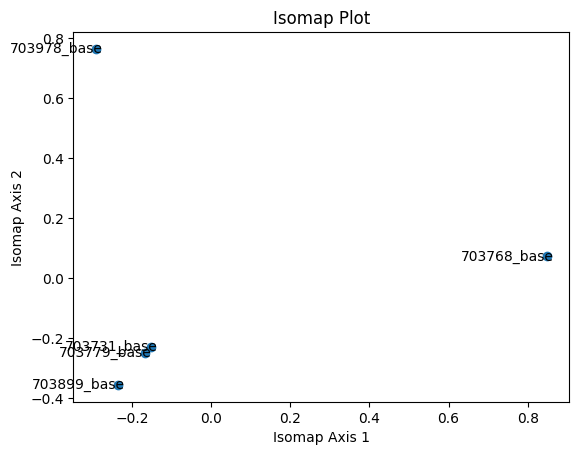

<Figure size 1000x800 with 0 Axes>

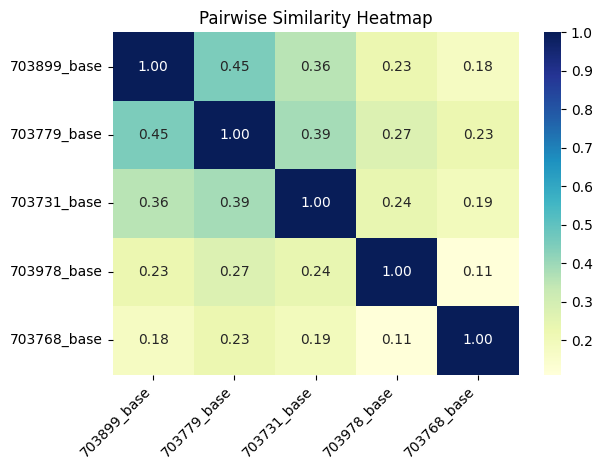

<Figure size 1000x800 with 0 Axes>

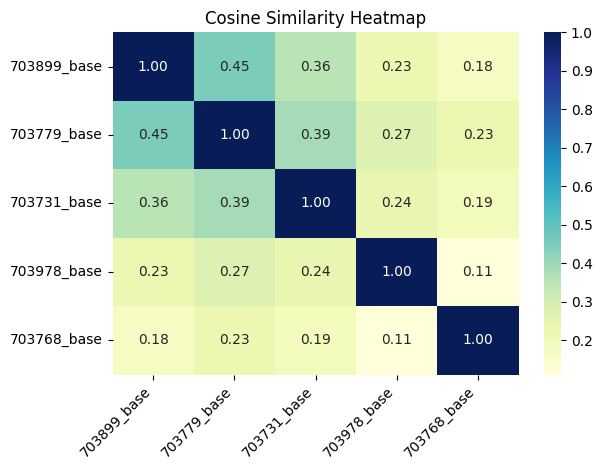

<Figure size 1000x800 with 0 Axes>

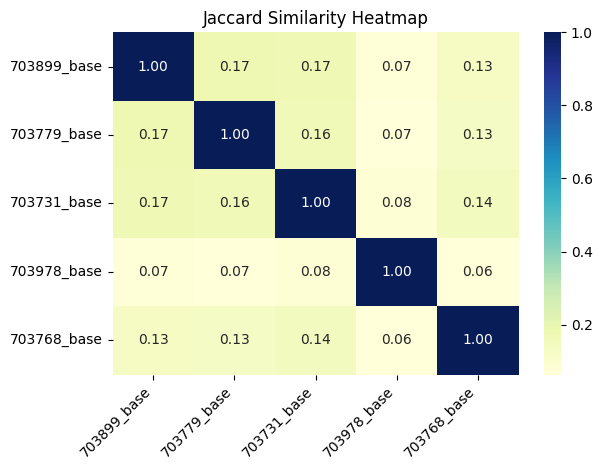

<Figure size 1000x800 with 0 Axes>

In [215]:
isomap_plot(mini_titles, mini_matrix)
heatmap_plot(mini_titles, mini_sims)

# Bringing in the Big Dataset

Now I can bring in the rest of the data from the file `rav_shechter`, which has about 4,000 shiurim.

In [219]:
path = r'/home/jupyter-sarale2003@gmail.c-2cf43/Machine-Learning-sp24/notebooks/FinalProject/rav_shachter'
file_names = get_file_names(path)

'
/home/jupyter-sarale2003@gmail.c-2cf43/Machine-Learning-sp24/notebooks/FinalProject/rav_shachter' is a directory.


In [216]:
texts, titles = generate_titles_texts(file_names[:100])
matrix = create_matrix(texts)
sims   = similarities(matrix)


Vocab
 ['00' '000' '10' ... 'תתקוי' 'תתקן' 'תתת'] -> length 91821

Pairwise Similarity (100, 100)

Cosine Similarity (100, 100)

Jaccard Similarity (100, 100)


Now to visualize. We can't visualize all the documents, as there are too many, but we can try the first 10.


Vocab
 ['00' '000' '10' ... 'תתקדם' 'תתקווי' 'תתקן'] -> length 46512


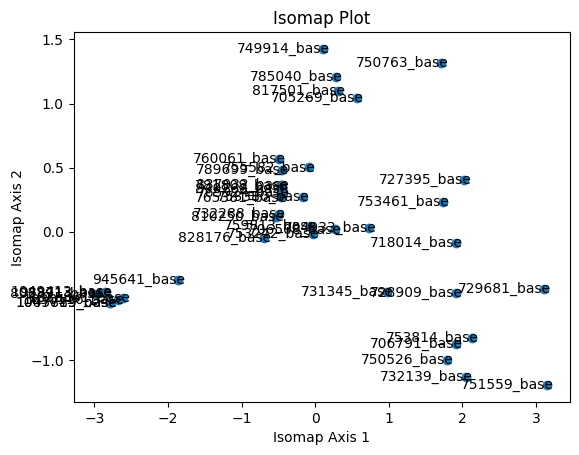

<Figure size 1000x800 with 0 Axes>

In [217]:
size = 40
texts_slice, titles_slice = texts[:size], titles[:size]
slice_matrix = create_matrix(texts_slice)
isomap_plot(titles_slice, slice_matrix)


Vocab
 ['1000' '11' '14' ... 'תתהי' 'תתול' 'תתן'] -> length 18409

Pairwise Similarity (12, 12)

Cosine Similarity (12, 12)

Jaccard Similarity (12, 12)


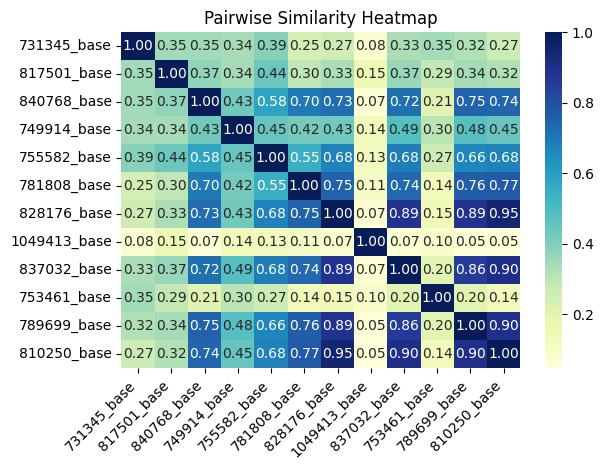

<Figure size 1000x800 with 0 Axes>

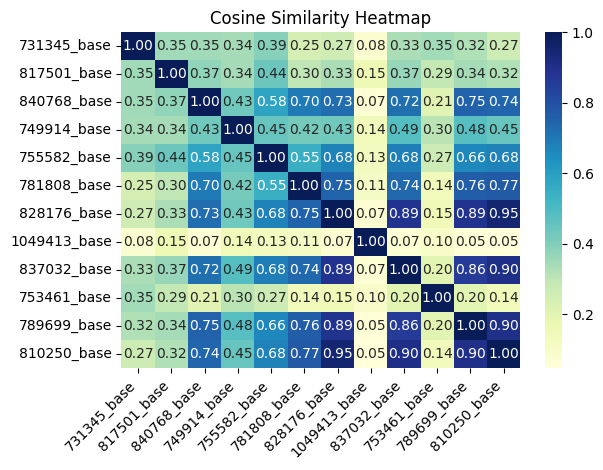

<Figure size 1000x800 with 0 Axes>

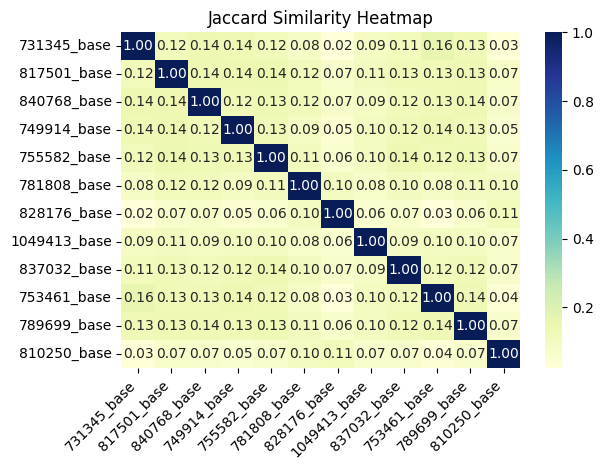

<Figure size 1000x800 with 0 Axes>

In [218]:
size = 12
texts_slice, titles_slice = texts[:size], titles[:size]
slice_matrix = create_matrix(texts_slice)
heatmap_plot(titles_slice, similarities(slice_matrix))